# Western US Bootstrap test

##### Toy code to emulate bootstrapping of forest mortality satellite data analysis in Western US, paired with statistical tests for comparison of statistical significance
##### NOTE: This notebook example shows the sensitivity of the bootstrap tests to number of bootstrap repititions. A companion notebook (02_toy_bootstrap_SampleSize_sensitivity.ipynb) shows the sensitivity of the bootstrap tests to sample size.


## Generate data

We will emulate real distributions of summer-averaged TROPOMI SIF for mortality and control populations for this test, as shown in the figure below. The original size of Mortality pixel group is 11 in this case, and the original size of Control pixel group is much larger (I estimate ~300).

For emulating SIF, we will use year 2021, which shows an obvious difference in distributions, and year 2022, which doesn't show an obvious difference in distributions. We want to test the null hypothesis that the Mortality and Control samples could have been drawn from the same population distribution.

![Actual distributions of TROPOMI SIF for mortality vs. control](https://home.chpc.utah.edu/~u6017162/bootstrap_example/ts_TROPOMI_SIF_2023disturb_v_healthy_WUS_05d_1yrdiff_ENSEMBLE_MEAN.png)

# Year 2021 (obvious difference in distributions)


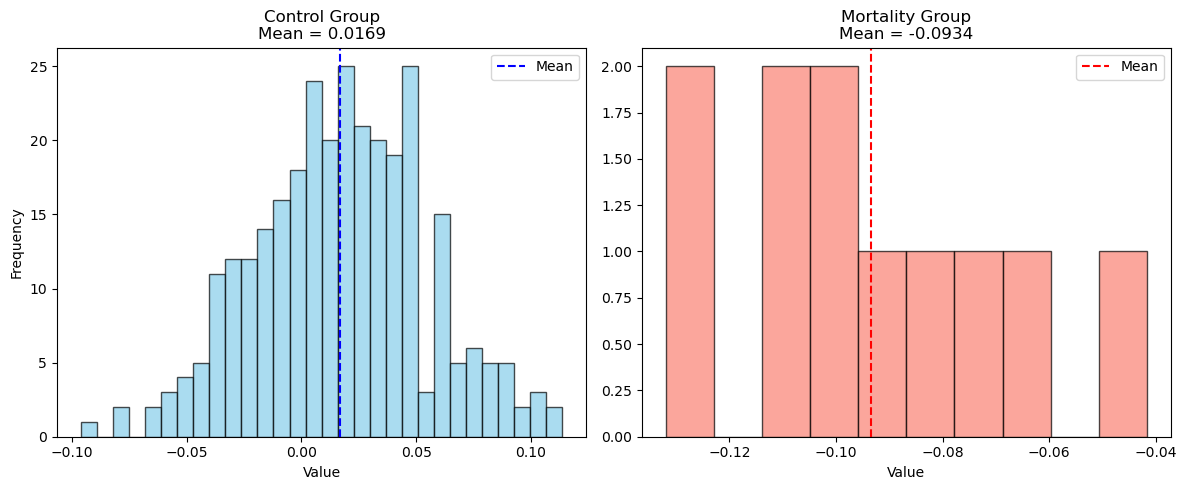

In [1]:
# Import relevant packages
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt

### MAIN PARAMETERS:
MORT_MEAN = -0.08086 # taken from real TROPOMI SIF mean & distr
MORT_STD = 0.02391 # taken from real TROPOMI SIF mean & distr
MORT_n = 11 # approx sample size of mortality pixels for 2022
CTRL_MEAN = 0.01401 ## taken from real TROPOMI SIF mean & distr
CTRL_STD = 0.03935 # taken from real TROPOMI SIF mean & distr
CTRL_n = 300 # approx sample size of control pixels

# Create a RandomState instance with a specific seed
seed_ctrl = 1
seed_mort = 2

### make 2 random variables with normal distributions, differing means and variances
# Generate random numbers for the control group
rng_ctrl = np.random.RandomState(seed_ctrl)
ctrl = rng_ctrl.normal(CTRL_MEAN, CTRL_STD, CTRL_n)

# Generate random numbers for the mortality group
rng_mort = np.random.RandomState(seed_mort)
mort = rng_mort.normal(MORT_MEAN, MORT_STD, MORT_n)

# Calculate means
mean_ctrl = np.mean(ctrl)
mean_mort = np.mean(mort)
actual_mean = mean_mort - mean_ctrl


# Plot side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot ctrl histogram
axes[0].hist(ctrl, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(mean_ctrl, color='blue', linestyle='dashed', linewidth=1.5, label=f'Mean')
axes[0].set_title(f'Control Group\nMean = {mean_ctrl:.4f}')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot mort histogram
axes[1].hist(mort, bins=10, color='salmon', edgecolor='black', alpha=0.7)
axes[1].axvline(mean_mort, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean')
axes[1].set_title(f'Mortality Group\nMean = {mean_mort:.4f}')
axes[1].set_xlabel('Value')
axes[1].legend()

# Display plot
plt.tight_layout()
plt.show()



# Statistical tests

0. Bootstrap confidence intervals
   - The standard utility of bootstrapping is to estimate the confidence intervals of a statistic (in this case, the difference in means between two groups)
   - Non-parametric (does not assume normality of data or equal variances in groups)

To complement the confidence intervals, we can also perform statistical tests between each repition of sample selection to test whether those means and distributions are different.
1. Student's t-test
   - A basic way to test the differences between groups to see if they are different from 0
   - Assumes normality of data and equal variances in groups __(likely not the case in all our comparisons)__

2. Analysis of Variance (ANOVA)
   - Basically a t-test, but can be used for 2 or more groups
   - This is what we've using to compare Mortality and Control up until now
   - Assumes normality of data and equal variances in groups __(likely not the case in all our comparisons)__

3. Mann-Whitney U test
   - Non-parametric test for comparing the "central tendency" of two independent samples (i.e., medians)
   - Does not assume normality of data or equal variances in groups
   - __sample sizes of groups do NOT have to be equal__

4. Wilcoxon signed-rank test
   - Non-parametric test for comparing two paired samples (i.e. this mortality pixel is paired with a similar control pixel, etc)
   - Does not assume normality of data or equal variances in groups
   - __sample sizes of groups MUST be equal__

5. Kolmogorov-Smirnov test
   - Non-parametric test for comparing two independent samples with continuous distributions
   - Does not assume normality of data or equal variances in groups
   - __sample sizes of groups do NOT have to be equal__




## Sensitivity test - number of bootstrap repetitions

We will define two variables, _a_ and _b_, where
_a_ = number of bootstrap repetitions, and
_b_ = number of bootstrap samples.

Let's perform a suite of statistical tests within the bootstrapping to compare sensitivity to number of bootstrap repetitions.

For this first test, we will set the sample size equal to the smaller of the two samples, which in this case is the mortality sample size

In [2]:
# Load stats packages
from scipy.stats import ttest_1samp
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import ks_2samp

# Set up empty arrays to store the MEAN confidence intervals and MEAN p-values for each value of a
conf_int_low_arr = []
conf_int_high_arr = []
mean_diff_arr = []

mean_p_values_ttest_arr = []
mean_p_values_ANOVA_arr = []
mean_p_values_mannwhitney_arr = []
mean_p_values_wilcoxon_arr = []
mean_p_values_ks_arr = []

# Values for a (number of bootstrap repetitions)
a_values = [10, 20, 30, 50, 100, 250, 500, 1000, 2000, 3000, 5000, 10000]

# Loop over the different values of a
for a in a_values:

   print(f'a = {a}')

   # Step 2: Manual bootstrap resampling with diff_means function

   # set up arrays to store resampled differences and p-values
   resampled_mean_diffs_arr = []
   p_values_ttest_arr = []
   p_values_ANOVA_arr = []
   p_values_mannwhitney_arr = []
   p_values_wilcoxon_arr = []
   p_values_ks_arr = []

   # Loop over the number of bootstrap samples
   for _ in range(a):
      # Resample independently with replacement
      resampled_mort = np.random.choice(mort, size=MORT_n, replace=True)
      resampled_ctrl = np.random.choice(ctrl, size=MORT_n, replace=True)
      resampled_diffs = resampled_mort - resampled_ctrl

      # Calculate difference in means for resampled data
      resampled_mean_diffs_arr.append(np.mean(resampled_mort) - np.mean(resampled_ctrl))
      
      ### Perform statistical tests on resampled Mortality and Control data
      # Student's t-test (are diffs different from 0?)
      t,p = ttest_1samp(resampled_diffs, 0) 
      p_values_ttest_arr.append(p)

      # ANOVA (are means different?)
      f,p = f_oneway(resampled_ctrl, resampled_mort)
      p_values_ANOVA_arr.append(p)

      # Mann-Whitney U test (are distributions different?)
      u,p = mannwhitneyu(resampled_ctrl, resampled_mort)
      p_values_mannwhitney_arr.append(p)

      # Wilcoxon signed-rank test (is one distribution greater than the other?)
      w,p = wilcoxon(resampled_ctrl, resampled_mort)
      p_values_wilcoxon_arr.append(p)

      # Kolmogorov-Smirnov test (are distributions different?)
      d,p = ks_2samp(resampled_ctrl, resampled_mort)
      p_values_ks_arr.append(p)


   # Convert to numpy array for easy manipulation
   resampled_mean_diffs_arr = np.array(resampled_mean_diffs_arr)
   p_values_ttest_arr = np.array(p_values_ttest_arr)
   p_values_ANOVA_arr = np.array(p_values_ANOVA_arr)
   p_values_mannwhitney_arr = np.array(p_values_mannwhitney_arr)
   p_values_wilcoxon_arr = np.array(p_values_wilcoxon_arr)
   p_values_ks_arr = np.array(p_values_ks_arr)
   
   # Step 3: Calculate confidence interval
   conf_level = 0.95
   lower_percentile = (1 - conf_level) / 2 * 100
   upper_percentile = (1 + conf_level) / 2 * 100
   ci_lower, ci_upper = np.percentile(resampled_mean_diffs_arr, [lower_percentile, upper_percentile])

   # Step 4: Calculate mean p-values from the statistical tests
   mean_p_ttest_arr = np.mean(p_values_ttest_arr)
   mean_p_ANOVA_arr = np.mean(p_values_ANOVA_arr)
   mean_p_mannwhitney_arr = np.mean(p_values_mannwhitney_arr)
   mean_p_wilcoxon_arr = np.mean(p_values_wilcoxon_arr)
   mean_p_ks_arr = np.mean(p_values_ks_arr)

   # Store the confidence interval values for plotting
   conf_int_low_arr.append(ci_lower)
   conf_int_high_arr.append(ci_upper)
   mean_diff_arr.append(np.mean(resampled_mean_diffs_arr))

   # Store the p values for plotting
   mean_p_values_ttest_arr.append(mean_p_ttest_arr)
   mean_p_values_ANOVA_arr.append(mean_p_ANOVA_arr)
   mean_p_values_mannwhitney_arr.append(mean_p_mannwhitney_arr)
   mean_p_values_wilcoxon_arr.append(mean_p_wilcoxon_arr)
   mean_p_values_ks_arr.append(mean_p_ks_arr)
   
   # end loop

print('done')



a = 10
a = 20
a = 30
a = 50
a = 100
a = 250
a = 500
a = 1000
a = 2000
a = 3000
a = 5000
a = 10000
done


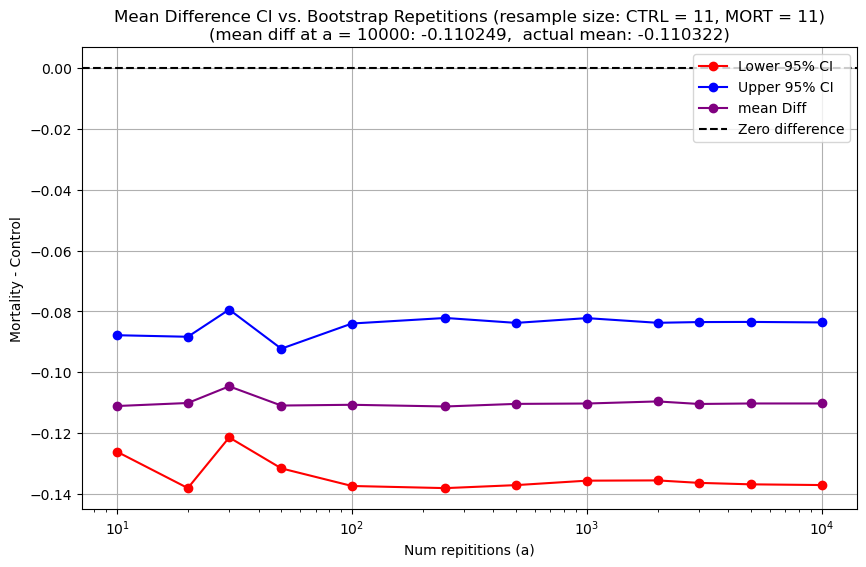

In [3]:

# Plot the confidence intervals as a function of a
plt.figure(figsize=(10, 6))
plt.plot(a_values, conf_int_low_arr, label='Lower 95% CI', color='red', marker='o')
plt.plot(a_values, conf_int_high_arr, label='Upper 95% CI', color='blue', marker='o')
plt.plot(a_values, mean_diff_arr, label='mean Diff', color='purple', marker='o')
plt.axhline(0, linestyle = '--', color = 'black', label='Zero difference')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Num repititions (a)')
plt.ylabel('Mortality - Control')
plt.title(f'Mean Difference CI vs. Bootstrap Repetitions (resample size: CTRL = {MORT_n}, MORT = {MORT_n})\n(mean diff at a = 10000: {mean_diff_arr[-1]:3f},  actual mean: {actual_mean:3f})')
plt.legend()
plt.grid(True)
plt.show()


#### NOTE:
A confidence interval which includes zero (denoted by the black dashed line) indicates that we do not have confidence that the difference in means is statistically different from 0.
i.e. We cannot reject the null hypothesis that the Mortality and Control samples could have been drawn from the same population distribution.

The opposite is true when a confidence interval does NOT include zero. 

Here the confidence interval pretty much never includes zero, meaning we're pretty sure the Mortality and Control samples have different means

#### Sensitivity of p-values to number of bootstrap repetitions

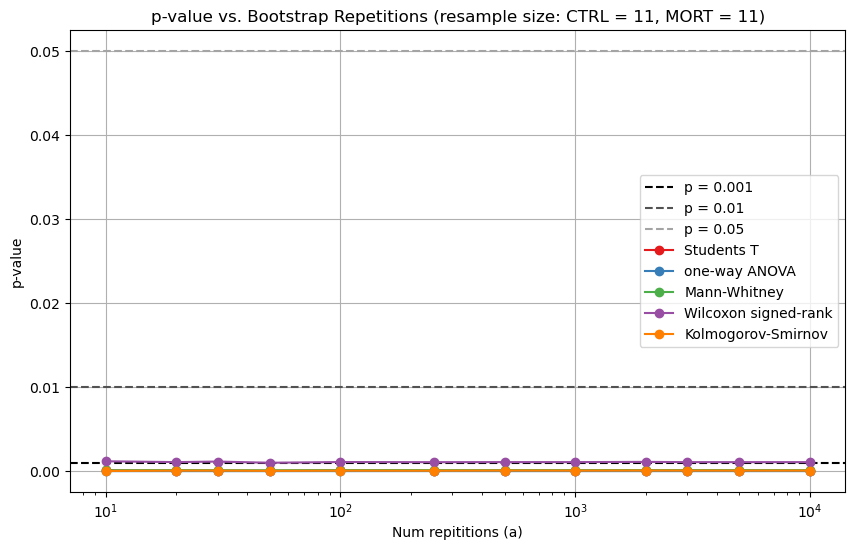

In [ ]:
# Plot the p_value as a function of a
plt.figure(figsize=(10, 6))
plt.axhline(0.001, linestyle = '--', color = 'black', label='p = 0.001')
plt.axhline(0.01, linestyle = '--', color = '#525252', label='p = 0.01')
plt.axhline(0.05, linestyle = '--', color = '#a4a4a4', label='p = 0.05')
plt.plot(a_values, mean_p_values_ttest_arr, label='Students T', color='#e41a1c', marker='o')
plt.plot(a_values, mean_p_values_ANOVA_arr, label='one-way ANOVA', color='#377eb8', marker='o') 
plt.plot(a_values, mean_p_values_mannwhitney_arr, label='Mann-Whitney', color='#4daf4a', marker='o')
plt.plot(a_values, mean_p_values_wilcoxon_arr, label='Wilcoxon signed-rank', color='#984ea3', marker='o')
plt.plot(a_values, mean_p_values_ks_arr, label='Kolmogorov-Smirnov', color='#ff7f00', marker='o')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Num repititions (a)')
plt.ylabel('p-value')
plt.title(f'p-value vs. Bootstrap Repetitions (resample size: CTRL = {MORT_n}, MORT = {MORT_n})')
plt.legend()
plt.grid(True)
plt.show()

The p-values are super small. All of them are much less than 0.01.

# Year 2022 (Distributions are not obviously different)

![Actual distributions of TROPOMI SIF for mortality vs. control](https://home.chpc.utah.edu/~u6017162/bootstrap_example/ts_TROPOMI_SIF_2023disturb_v_healthy_WUS_05d_1yrdiff_ENSEMBLE_MEAN.png)

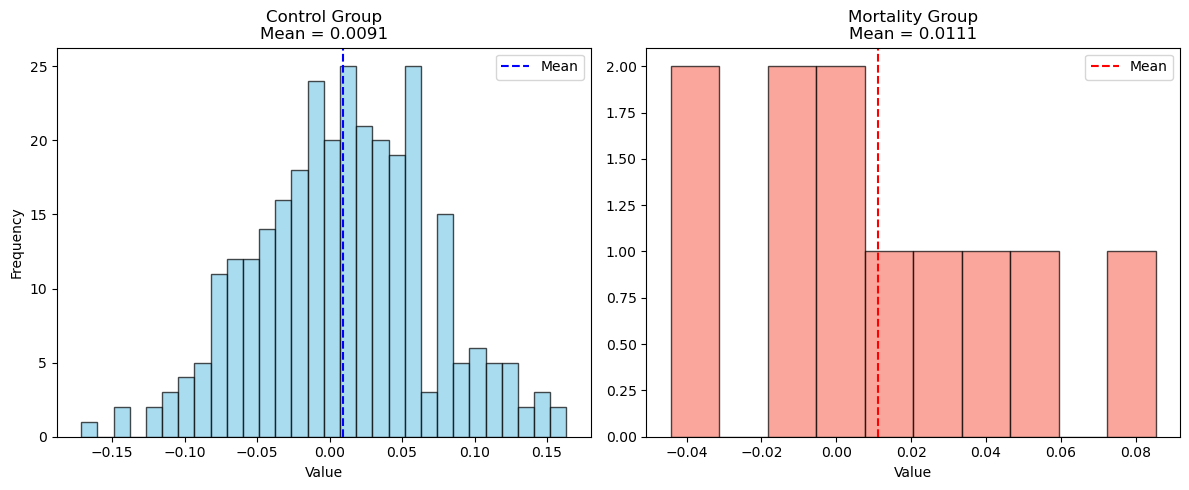

In [5]:

### MAIN PARAMETERS:
MORT_MEAN = 0.02905 # taken from real TROPOMI SIF mean & distr
MORT_STD = 0.03431 # taken from real TROPOMI SIF mean & distr
MORT_n = 11 # approx sample size of mortality pixels for 2022
CTRL_MEAN = 0.004388 ## taken from real TROPOMI SIF mean & distr
CTRL_STD = 0.06289 # taken from real TROPOMI SIF mean & distr
CTRL_n = 300 # approx sample size of control pixels

# Create a RandomState instance with a specific seed
seed_ctrl = 1
seed_mort = 2

### make 2 random variables with normal distributions, differing means and variances
# Generate random numbers for the control group
rng_ctrl = np.random.RandomState(seed_ctrl)
ctrl = rng_ctrl.normal(CTRL_MEAN, CTRL_STD, CTRL_n)

# Generate random numbers for the mortality group
rng_mort = np.random.RandomState(seed_mort)
mort = rng_mort.normal(MORT_MEAN, MORT_STD, MORT_n)

# Calculate means
mean_ctrl = np.mean(ctrl)
mean_mort = np.mean(mort)
actual_mean = mean_mort - mean_ctrl


# Plot side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot ctrl histogram
axes[0].hist(ctrl, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(mean_ctrl, color='blue', linestyle='dashed', linewidth=1.5, label=f'Mean')
axes[0].set_title(f'Control Group\nMean = {mean_ctrl:.4f}')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot mort histogram
axes[1].hist(mort, bins=10, color='salmon', edgecolor='black', alpha=0.7)
axes[1].axvline(mean_mort, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean')
axes[1].set_title(f'Mortality Group\nMean = {mean_mort:.4f}')
axes[1].set_xlabel('Value')
axes[1].legend()

# Display plot
plt.tight_layout()
plt.show()



In [6]:
# Set up empty arrays to store the MEAN confidence intervals and MEAN p-values for each value of a
conf_int_low_arr = []
conf_int_high_arr = []
mean_diff_arr = []

mean_p_values_ttest_arr = []
mean_p_values_ANOVA_arr = []
mean_p_values_mannwhitney_arr = []
mean_p_values_wilcoxon_arr = []
mean_p_values_ks_arr = []

# Values for a (number of bootstrap repetitions)
a_values = [10, 20, 30, 50, 100, 250, 500, 1000, 2000, 3000, 5000, 10000]

# Loop over the different values of a
for a in a_values:

   print(f'a = {a}')

   # Step 2: Manual bootstrap resampling with diff_means function

   # set up arrays to store resampled differences and p-values
   resampled_mean_diffs_arr = []
   p_values_ttest_arr = []
   p_values_ANOVA_arr = []
   p_values_mannwhitney_arr = []
   p_values_wilcoxon_arr = []
   p_values_ks_arr = []

   # Loop over the number of bootstrap samples
   for _ in range(a):
      # Resample independently with replacement
      resampled_mort = np.random.choice(mort, size=MORT_n, replace=True)
      resampled_ctrl = np.random.choice(ctrl, size=MORT_n, replace=True)
      resampled_diffs = resampled_mort - resampled_ctrl

      # Calculate difference in means for resampled data
      resampled_mean_diffs_arr.append(np.mean(resampled_mort) - np.mean(resampled_ctrl))
      
      ### Perform statistical tests on resampled Mortality and Control data
      # Student's t-test (are diffs different from 0?)
      t,p = ttest_1samp(resampled_diffs, 0) 
      p_values_ttest_arr.append(p)

      # ANOVA (are means different?)
      f,p = f_oneway(resampled_ctrl, resampled_mort)
      p_values_ANOVA_arr.append(p)

      # Mann-Whitney U test (are distributions different?)
      u,p = mannwhitneyu(resampled_ctrl, resampled_mort)
      p_values_mannwhitney_arr.append(p)

      # Wilcoxon signed-rank test (is one distribution greater than the other?)
      w,p = wilcoxon(resampled_ctrl, resampled_mort)
      p_values_wilcoxon_arr.append(p)

      # Kolmogorov-Smirnov test (are distributions different?)
      d,p = ks_2samp(resampled_ctrl, resampled_mort)
      p_values_ks_arr.append(p)


   # Convert to numpy array for easy manipulation
   resampled_mean_diffs_arr = np.array(resampled_mean_diffs_arr)
   p_values_ttest_arr = np.array(p_values_ttest_arr)
   p_values_ANOVA_arr = np.array(p_values_ANOVA_arr)
   p_values_mannwhitney_arr = np.array(p_values_mannwhitney_arr)
   p_values_wilcoxon_arr = np.array(p_values_wilcoxon_arr)
   p_values_ks_arr = np.array(p_values_ks_arr)
   
   # Step 3: Calculate confidence interval
   conf_level = 0.95
   lower_percentile = (1 - conf_level) / 2 * 100
   upper_percentile = (1 + conf_level) / 2 * 100
   ci_lower, ci_upper = np.percentile(resampled_mean_diffs_arr, [lower_percentile, upper_percentile])

   # Step 4: Calculate mean p-values from the statistical tests
   mean_p_ttest_arr = np.mean(p_values_ttest_arr)
   mean_p_ANOVA_arr = np.mean(p_values_ANOVA_arr)
   mean_p_mannwhitney_arr = np.mean(p_values_mannwhitney_arr)
   mean_p_wilcoxon_arr = np.mean(p_values_wilcoxon_arr)
   mean_p_ks_arr = np.mean(p_values_ks_arr)

   # Store the confidence interval values for plotting
   conf_int_low_arr.append(ci_lower)
   conf_int_high_arr.append(ci_upper)
   mean_diff_arr.append(np.mean(resampled_mean_diffs_arr))

   # Store the p values for plotting
   mean_p_values_ttest_arr.append(mean_p_ttest_arr)
   mean_p_values_ANOVA_arr.append(mean_p_ANOVA_arr)
   mean_p_values_mannwhitney_arr.append(mean_p_mannwhitney_arr)
   mean_p_values_wilcoxon_arr.append(mean_p_wilcoxon_arr)
   mean_p_values_ks_arr.append(mean_p_ks_arr)
   
   # end loop

print('done')



a = 10
a = 20
a = 30
a = 50
a = 100
a = 250
a = 500
a = 1000
a = 2000
a = 3000
a = 5000
a = 10000
done


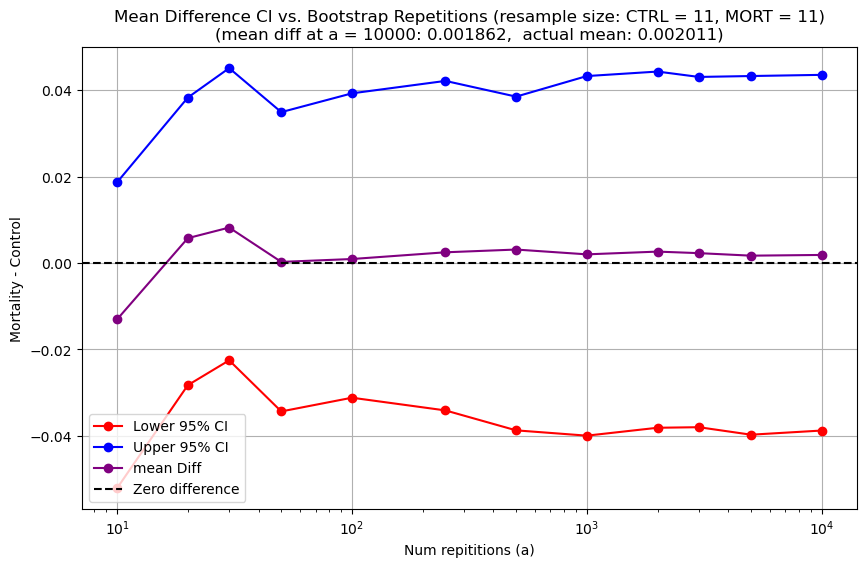

In [7]:

# Plot the confidence intervals as a function of a
plt.figure(figsize=(10, 6))
plt.plot(a_values, conf_int_low_arr, label='Lower 95% CI', color='red', marker='o')
plt.plot(a_values, conf_int_high_arr, label='Upper 95% CI', color='blue', marker='o')
plt.plot(a_values, mean_diff_arr, label='mean Diff', color='purple', marker='o')
plt.axhline(0, linestyle = '--', color = 'black', label='Zero difference')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Num repititions (a)')
plt.ylabel('Mortality - Control')
plt.title(f'Mean Difference CI vs. Bootstrap Repetitions (resample size: CTRL = {MORT_n}, MORT = {MORT_n})\n(mean diff at a = 10000: {mean_diff_arr[-1]:3f},  actual mean: {actual_mean:3f})')
plt.legend()
plt.grid(True)
plt.show()


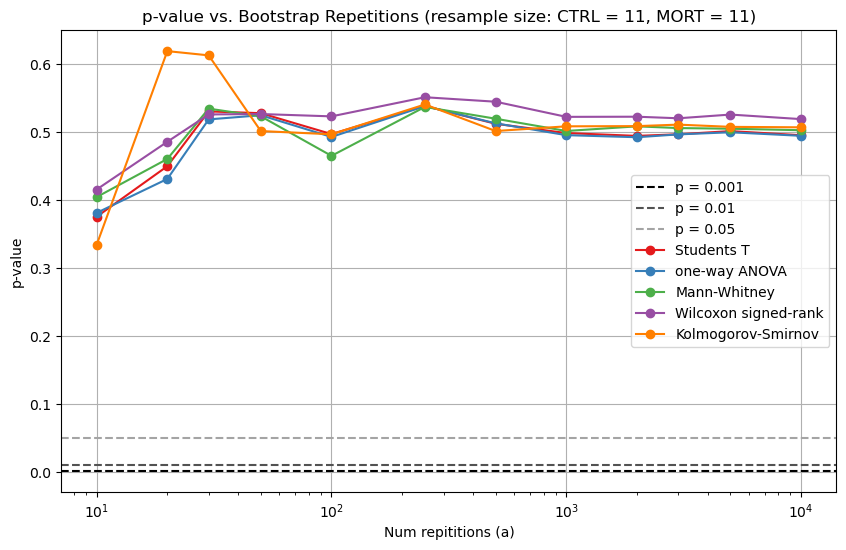

In [9]:
# Plot the p_value as a function of a
plt.figure(figsize=(10, 6))
plt.axhline(0.001, linestyle = '--', color = 'black', label='p = 0.001')
plt.axhline(0.01, linestyle = '--', color = '#525252', label='p = 0.01')
plt.axhline(0.05, linestyle = '--', color = '#a4a4a4', label='p = 0.05')
plt.plot(a_values, mean_p_values_ttest_arr, label='Students T', color='#e41a1c', marker='o')
plt.plot(a_values, mean_p_values_ANOVA_arr, label='one-way ANOVA', color='#377eb8', marker='o') 
plt.plot(a_values, mean_p_values_mannwhitney_arr, label='Mann-Whitney', color='#4daf4a', marker='o')
plt.plot(a_values, mean_p_values_wilcoxon_arr, label='Wilcoxon signed-rank', color='#984ea3', marker='o')
plt.plot(a_values, mean_p_values_ks_arr, label='Kolmogorov-Smirnov', color='#ff7f00', marker='o')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Num repititions (a)')
plt.ylabel('p-value')
plt.title(f'p-value vs. Bootstrap Repetitions (resample size: CTRL = {MORT_n}, MORT = {MORT_n})')
plt.legend()
plt.grid(True)
plt.show()


The p-values are generally clustered around 0.5 which indicates that we don't have enough confidence to reject the null hypothesis that the mortality and control are drawn from the same population distribution. So, these samples are not statistically significantly different, and it doesn't seem to matter which of these tests we used to verify that.


### NOTE!!!
In this example we've created toy distributions which have a gaussian (normal) shape. We don't know that this is the case when working with the real data, so while it seems ok here that the Student's t-test and ANOVA are giving us the same results as the Mann-Whitney U test, Wilcoxon signed-rank test, and Kolmogorov-Smirnov test, this may not be the case with the real data. So it's likely more conservative to use the non-parametric tests in the real analysis.

